In [1]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import lmdb

import numpy as np
import PIL
import random
from IPython.core.display import Image, display

import torch
import torch.nn as nn
import torch.optim as optim
import torch.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset

from torch.autograd import Variable
from torch.autograd import Function
from torch.autograd import gradcheck

import torchvision
import torchvision.transforms as transforms

CUDA_DEVICE = 3

In [2]:
def imshow(img):
#     npimg = img.numpy().astype('uint8')
    npimg = np.asarray(img)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

def tuple_imshow(images):
#     npimg = img.numpy().astype('uint8')
    invert = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                            std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                          std = [ 1., 1., 1. ]),
                                    ])
    resized = invert(images[0])
    original = invert(images[1])
    np_res = np.asarray(resized)
    np_orig = np.asarray(original)
    
    fig = plt.figure(figsize=(20, 8))
    orig_plot = fig.add_subplot(121)
    orig_plot.imshow((np.transpose(np_orig, (1, 2, 0))))
    res_plot = fig.add_subplot(122)
    res_plot.imshow((np.transpose(np_res, (1, 2, 0))))

In [3]:
class HR_dataset(Dataset):
    def __init__(self, validation=False, size=180):
        self.val = validation
        self.size = size
        self.downscale_ratio = 2
        self.data = torchvision.datasets.ImageFolder('RandomDset_1/')  # датасет состоит из разных 
                                                                       # картинок с разным масштабом сцены
                                                                       # - AUGMENTATION #0'''
        self.validationData = torchvision.datasets.ImageFolder('image_SRF_2/')
        self.totensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
        ])
    
    def downscale(self, image, size=256):
#         sample = self.data.__getitem__(5)[0]
        new_size = (size[0] // self.downscale_ratio), (size[1] // self.downscale_ratio)
        # Сжатие
        method = int(1 + 3*np.random.sample())                        # - Уменьшение картинки рандомным методом
        downscale = transforms.Resize(new_size, interpolation=method) # - AUGMENTATION #1
        upscale = transforms.Resize(size, interpolation=2)
        image = downscale(image)
        image = upscale(image)
        image = self.totensor(image)
        return image
    
    def __getitem__(self, idx):
        if self.val == True:
            image, _ = self.validationData.__getitem__(idx)
        else:
            image, _ = self.data.__getitem__(idx)
        
        size = image.size[1], image.size[0]
        if self.val == False:
            size = self.size
            crop = transforms.RandomCrop(size) # обрезка - небольшой размер для бОльшего размера батча
            image = crop(image)
            size = image.size[1], image.size[0]
#         image = transforms.RandomAffine((-180, 180)).__call__(image)
        hr_image = self.totensor(image)
        lr_image = self.downscale(image, size)
        return lr_image, hr_image
    
    def __len__(self):
        if self.val:
            return self.validationData.__len__()
        else:
            return self.data.__len__()

In [4]:
train_dataset = HR_dataset(size=128)
valid_dataset = HR_dataset(validation=True, size=100)

In [5]:
from math import sqrt

class Conv_ReLU_Block(nn.Module):
    def __init__(self, kernel=3):
        super(Conv_ReLU_Block, self).__init__()
        kernel = 3
        self.conv = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=kernel, stride=1, padding=int((kernel-1)/2), bias=False)
        self.relu = nn.ReLU(inplace=True)
        
    def forward(self, x):
        return self.relu(self.conv(x))
        
class Net(nn.Module):
    def __init__(self, num_of_layers=18):
        super(Net, self).__init__()
        self.residual_layer = self.make_layer(Conv_ReLU_Block, num_of_layers)
        self.input = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1, bias=False)
        self.output = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=3, stride=1, padding=1, bias=False)
        self.relu = nn.ReLU(inplace=True)
    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, sqrt(2. / n))
                
    def make_layer(self, block, num_of_layer):
        layers = []
        kernel_size = 3
        for num in range(num_of_layer):
            layers.append(block(kernel=3*(num+1)))
        return nn.Sequential(*layers)

    def forward(self, x):
#         print("Size {}".format(x.size()))
#         print("Size {}".format(x.size()))
        residual = x
        out = self.relu(self.input(x))
        out = self.residual_layer(out)
        out = self.output(out)
        out = torch.add(out,residual)
        return out

In [18]:
from math import log10

def single_evaluate_and_show(sample):
    model.eval()
    print('eval')
    input = Variable(sample[0].unsqueeze(0).cuda(CUDA_DEVICE))
    target = Variable(sample[1].unsqueeze(0).cuda(CUDA_DEVICE))
    prediction = model(input) 
    mse_i = criterion(input, target)
    mse_m = criterion(prediction, target)
    psnr_i = 10 * log10(1 / mse_i)
    psnr_m = 10 * log10(1 / mse_m)
    
    result = (target, input, prediction)
    fig = plt.figure(figsize=(8, 20))
    plots = []
    for idx, image in enumerate(result, 1):
        image = image.data.squeeze(0)
        invert = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                            std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                    transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                          std = [ 1., 1., 1. ]),
                                    ])
        image = invert(image)
        image = np.asarray(image)
        plots.append(fig.add_subplot(3, 1, idx))
        plots[idx-1].imshow((np.transpose(image, (1, 2, 0))))
    print("Inter PSNR: {:.4f} dB".format(psnr_i))
    print("Model PSNR: {:.4f} dB".format(psnr_m))
    
def validation(model):
    input, target = valid_dataset.__getitem__(0)
    input, target = Variable(input.unsqueeze(0)).cuda(CUDA_DEVICE), Variable(target.unsqueeze(0)).cuda(CUDA_DEVICE)
    # не дописана модель
    input = model(input)
    return criterion(input, target)

In [7]:
def train(training_data_loader, model, optimizer, criterion, epoch, lr):

    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))
    loss_acc = 0
    loss_acc_return = 0
    for iteration, batch in enumerate(training_data_loader, 1):
        input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)

       
        input = input.cuda(CUDA_DEVICE)
        target = target.cuda(CUDA_DEVICE)

        loss = criterion(model(input), target)
        loss_acc += loss
        loss_acc_return += loss
        optimizer.zero_grad()
        loss.backward()
        
        max_grad_norm = 0.1 / lr
        nn.utils.clip_grad_norm(model.parameters(),max_grad_norm) 
        
        optimizer.step()
        
        show_every = 10

        if iteration % show_every == 0:
            loss_show = loss_acc / show_every
            loss_acc = 0
            print("===> Epoch[{}]({}/{}): Loss: {:.10f} ".format(epoch, iteration, len(training_data_loader), loss_show))
        
    return loss_acc_return / 1090

In [10]:
model = Net(num_of_layers=18).cuda(CUDA_DEVICE)
model.train()

Net(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (6): Conv_ReLU_Block(
      (conv): Conv2d(64, 

In [9]:
train_dataset = HR_dataset(size=40)
valid_dataset = HR_dataset(validation=True, size=100)

criterion = nn.MSELoss().cuda(CUDA_DEVICE)

In [10]:
lr = 0.1
minibatch_size = 20

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True, num_workers=2)
single_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1)

optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=False, weight_decay=0.0001)

Validation: 3.0288140773773193
Epoch = 0, lr = 0.1
===> Epoch[0](10/55): Loss: 0.5343727469 
===> Epoch[0](20/55): Loss: 0.0679969788 
===> Epoch[0](30/55): Loss: 0.0510567389 
===> Epoch[0](40/55): Loss: 0.0682183579 
===> Epoch[0](50/55): Loss: 0.0690131113 
Validation: 0.02955898456275463
Epoch = 1, lr = 0.1
===> Epoch[1](10/55): Loss: 0.0566596575 
===> Epoch[1](20/55): Loss: 0.0683993325 
===> Epoch[1](30/55): Loss: 0.0597843044 
===> Epoch[1](40/55): Loss: 0.0648004934 
===> Epoch[1](50/55): Loss: 0.0613661073 
Validation: 0.023348476737737656
Epoch = 2, lr = 0.1
===> Epoch[2](10/55): Loss: 0.0594230071 
===> Epoch[2](20/55): Loss: 0.0632442757 
===> Epoch[2](30/55): Loss: 0.0614070855 
===> Epoch[2](40/55): Loss: 0.0744919702 
===> Epoch[2](50/55): Loss: 0.0684854537 
Validation: 0.042951490730047226
Epoch = 3, lr = 0.1
===> Epoch[3](10/55): Loss: 0.0599181131 
===> Epoch[3](20/55): Loss: 0.0691610575 
===> Epoch[3](30/55): Loss: 0.0814801976 
===> Epoch[3](40/55): Loss: 0.07333

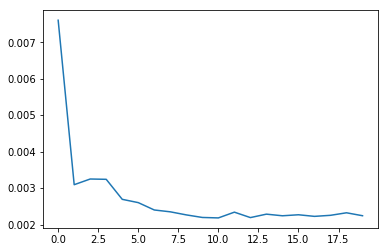

In [13]:
import warnings; warnings.simplefilter('ignore')
loss = []
for epoch in range(20):
    if epoch%1==0:
        val_res = validation(model)
        print("Validation: {}".format(val_res))
    l = train(train_loader, model, optimizer, criterion, epoch, lr)
    loss.append(l)
    
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
ax.clear()
ax.plot(loss)

In [14]:
torch.save(model, '/home/k.taletskiy/10_SuperResolution/vdsr')

eval
Inter PSNR: 10.9396 dB
Model PSNR: 16.7287 dB


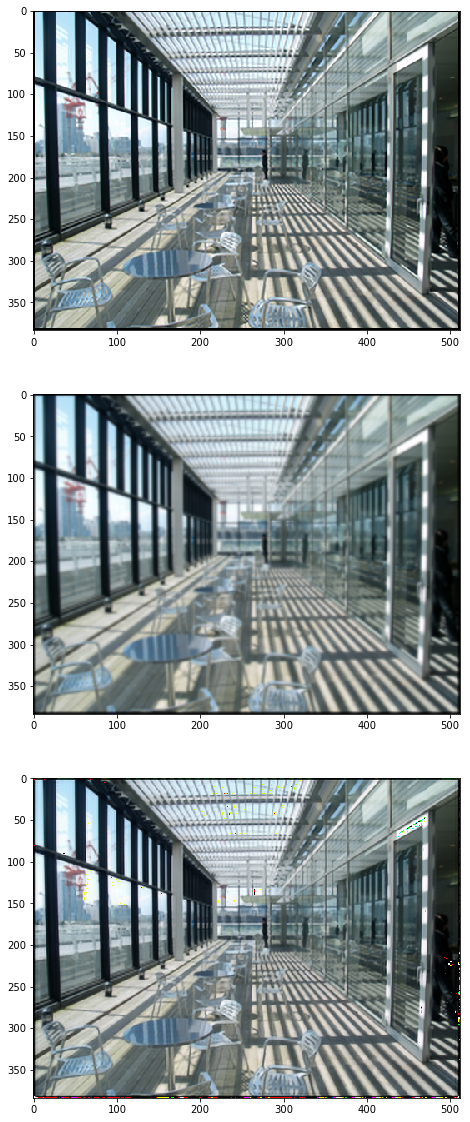

In [19]:
single_evaluate_and_show(valid_dataset.__getitem__(55))

In [21]:
class testUrbanDset(Dataset):
    def __init__(self):
        super(testUrbanDset, self).__init__()
        self.data = torchvision.datasets.ImageFolder('image_SRF_2')
        self.totensor = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

    def __getitem__(self, idx, crop=False, size=50):
        ccrop = transforms.CenterCrop(size)
        image, _ = self.data.__getitem__(idx)
        if crop:
            image = ccrop(image)
        image = self.totensor(image)
        
        label, _ = self.data.imgs[idx] # метод родительского класса Dataset. Возвращает строку с названием прочитанного файла.
        
        start, end = label.find('2/') + 2, label.find('/img')
        label = label[start:end]
        return image, label
    
    def get_examples(self, idx, crop=False, size=50):
        pics_and_labels = {}
        for i in range(11): # 11 - количество классов в датасете - по количеству методов (подходов)
            index = idx + 100 * i # в каждом классе по 100 картинок
            item = self.__getitem__(index, crop=crop, size=size)
            pics_and_labels.update([(item[1],item[0])])
        return pics_and_labels
    
    def __len__(self):
        return self.data.__len__()

In [30]:
test_dset = testUrbanDset()

def psnr(input, target, cuda=False):
    mse = nn.MSELoss()
    if cuda:
        mse = mse.cuda(CUDA_DEVICE)
    mse = mse(input, target)
    return 10 * log10(1.0 / mse)
#     return None

def print_pics(pics, lr, hr):
    pass

def test_and_compare(model, idx=0, crop=False, size=50):
    model.eval()
    
    recover = transforms.Compose([
        transforms.Normalize(mean=[ 0., 0., 0. ],
                             std=[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                             std=[ 1., 1., 1. ]),
    ])
    
    pics = test_dset.get_examples(idx, crop=crop, size=size)
    hr = pics.pop('HR')
    lr = pics.pop('LR')
    
    size = hr.size()[1]
    upscale = transforms.Compose([
        transforms.Normalize(mean=[ 0., 0., 0. ],
                             std=[ 1/0.229, 1/0.224, 1/0.225 ]),
        transforms.Normalize(mean=[ -0.485, -0.456, -0.406 ],
                             std=[ 1., 1., 1. ]),
        transforms.ToPILImage(),
        transforms.Resize(size, interpolation=2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ])
    
    upscaled = upscale(lr)
    model_input = Variable(upscaled.unsqueeze(0)).cuda(CUDA_DEVICE)
    target = Variable(hr.unsqueeze(0), requires_grad=False).cuda(CUDA_DEVICE)
    prediction = model(model_input)
    model_psnr = psnr(prediction, target, cuda=True)
    prediction = np.asarray(recover(prediction.squeeze(0)).data)
    
    hr = hr.cuda(CUDA_DEVICE)
    plots = []
    fig = plt.figure(figsize=(70, 80))
    for it, label in enumerate(pics):
#         image = transforms.ToTensor().__call__(pic[0])
        image = recover(pics[label])
        image = np.asarray(image)
        
        metric = psnr(pics[label].cuda(CUDA_DEVICE), hr, cuda=True)
    #         pics_labels_psnr = pics_labels_psnr.append(pic_label_psnr)

        plots.append(fig.add_subplot(12, 1, it+1))
        plots[it].set_title('{}\nPSNR: {:.4f} dB'.format(label, metric))
        plots[it].imshow((np.transpose(image, (1, 2, 0))))
        
    plots.append(fig.add_subplot(12, 1, 10))
    plots[9].set_title('VDSR\nPSNR: {:.4f} dB'.format(model_psnr))
    plots[9].imshow((np.transpose(prediction, (1, 2, 0))))
    
#     plots.append(fig.add_subplot(6, 2, 11))
#     plots[9].set_title('Upscaled')
#     plots[9].imshow((np.transpose(prediction, (1, 2, 0))))

In [ ]:
# model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr_nv')
test_and_compare(model, idx=2, crop=False, size=400)

In [ ]:
# model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr_nv')
test_and_compare(model, idx=50, crop=False, size=50)

In [ ]:
# model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr_nv')
test_and_compare(model, idx=50, crop=False, size=50)

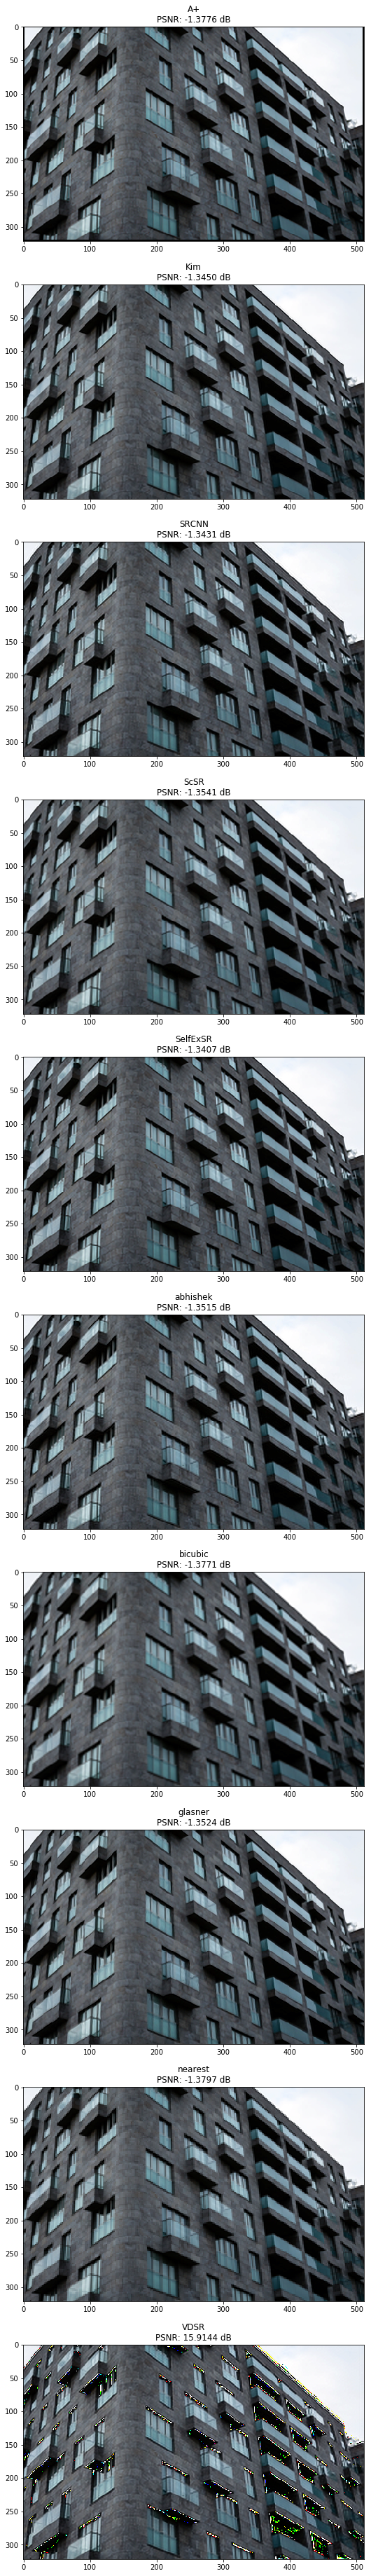

In [32]:
# model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr_nv')
test_and_compare(model, idx=0, crop=False, size=50)

In [20]:
torch.save(model, '/home/k.taletskiy/10_SuperResolution/vdsr_nv=meh')

In [13]:
model = torch.load('/home/k.taletskiy/10_SuperResolution/vdsr')
model.cuda(CUDA_DEVICE)

Net(
  (residual_layer): Sequential(
    (0): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (1): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (2): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (3): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (4): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (5): Conv_ReLU_Block(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (relu): ReLU(inplace)
    )
    (6): Conv_ReLU_Block(
      (conv): Conv2d(64, 